In [12]:
import numpy as np
import cv2
import os
from utils.utils import *
import matplotlib.pyplot as plt
import numpy as np

In [13]:
data_dir = './result/'

In [14]:
imgs_list = []
for data in os.listdir(data_dir):
    if data[-4:] == ".jpg":
        img = cv2.imread(data_dir + data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs_list.append(img)

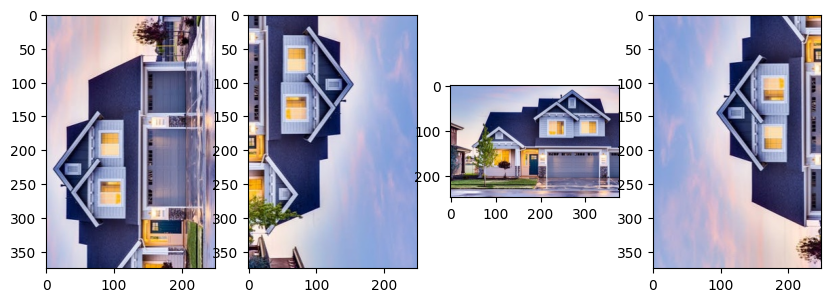

In [15]:
visualize(imgs_list)

In [16]:
for i in imgs_list:
    print(i.shape)

(375, 249, 3)
(375, 249, 3)
(249, 375, 3)
(375, 249, 3)


## 모든 배열의 이미지 크기를 같게 하여 합성 해보기
- 시간이 오래 걸림

In [8]:
# 모든 배열의 이미지를 동일하게 만들기 위함
max_shape = tuple(max(s) for s in zip(*(arr.shape for arr in imgs_list)))

In [9]:
# 각 배열의 shape를 동일하게 만들기 위한 최종 shape를 계산
padded_arrays = []
for arr in imgs_list:
    pads = [(0, d) for d in np.subtract(max_shape, arr.shape)]
    padded_arrays.append(np.pad(arr, pads, mode='constant'))

In [10]:
for i in padded_arrays:
    print(i.shape)

(375, 375, 3)
(375, 375, 3)
(375, 375, 3)
(375, 375, 3)


In [81]:
stitcher = cv2.Stitcher_create()
status, dst = stitcher.stitch(padded_arrays)
plt.imshow(dst)

: 

: 

# sift 알고리즘을 이용하여 특징점을 찾은 후 정합해 보기

In [54]:
gray1 = cv2.cvtColor(imgs_list[0], cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(imgs_list[2], cv2.COLOR_BGR2GRAY)

(375, 249) (249, 375)


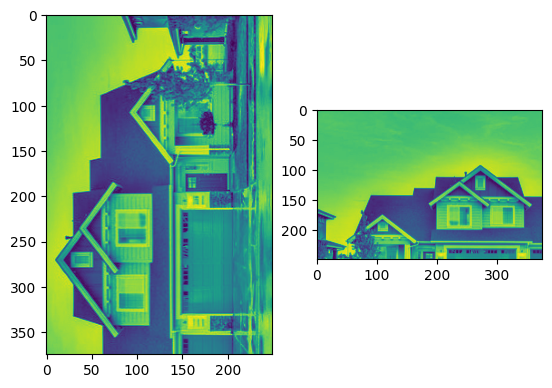

In [55]:
plt.subplot(1,2,1)
plt.imshow(gray1)
plt.subplot(1,2,2)
plt.imshow(gray2)

print(gray1.shape, gray2.shape)

In [57]:
gray2 = rotate(mirroring(gray2))

(375, 249)


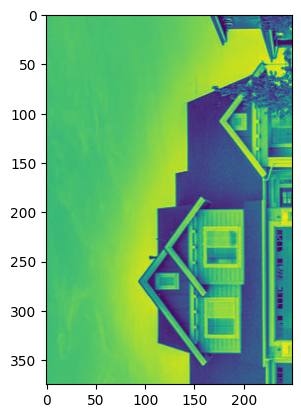

In [58]:
print(gray2.shape)
plt.imshow(gray2)

In [59]:
sift = cv2.SIFT_create()

In [60]:
# 특징점 검출 및 디스크립터 추출
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

print(f'img1 - {len(kp1)}features, img2 - {len(kp2)}features')

keypoints1 = np.float32([keypoint.pt for keypoint in kp1])
keypoints2 = np.float32([keypoint.pt for keypoint in kp2])

img1 - 653features, img2 - 395features


In [61]:
# 매칭
bf = cv2.BFMatcher(cv2.DIST_L2, crossCheck=True) # HAMMING distance는 orb에서 사용
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

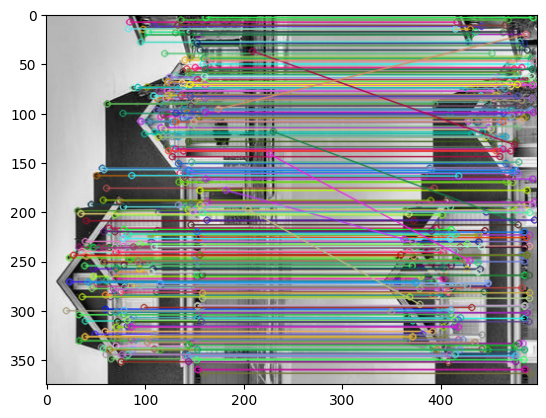

In [62]:
res = cv2.drawMatches(gray1, kp1, gray2, kp2, matches, None, \
                      flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

plt.imshow(res)

In [63]:
num_good_matches = 100
good_matches = matches[:num_good_matches]

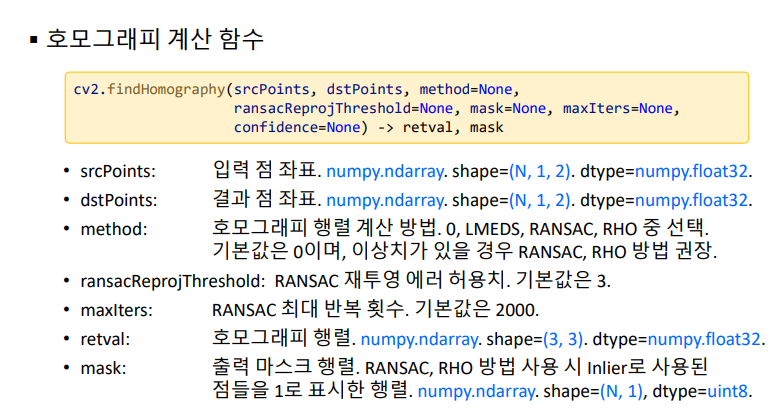

출처 : https://blog.naver.com/PostView.naver?blogId=engineerjkk&logNo=222263191204&parentCategoryNo=&categoryNo=30&viewDate=&isShowPopularPosts=true&from=search

In [64]:
# 매칭점 좌표 추출
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# 변환 행렬 계산
M, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC, 10.0) # 최소 4개의 대응점 필요

In [68]:
img1 = imgs_list[0]
img2 = rotate(mirroring(imgs_list[2]))

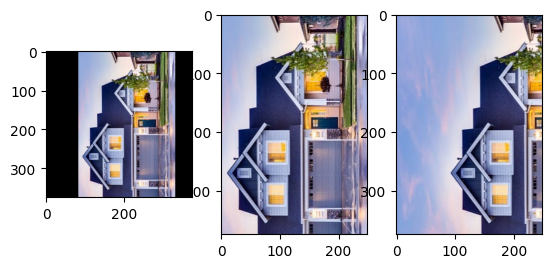

In [70]:
# 이미지 정합
result = cv2.warpPerspective(img1, M, (img1.shape[0], img2.shape[0]))

# 결과 출력
plt.subplot(1,3,1)
plt.imshow(result)
plt.subplot(1,3,2)
plt.imshow(img1)
plt.subplot(1,3,3)
plt.imshow(img2)

# 1, 3

In [85]:
# def image_merge(img1, img2):
#     gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#     gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#     sift = cv2.SIFT_create()
#     # 특징점 검출 및 디스크립터 추출
#     kp1, des1 = sift.detectAndCompute(gray1, None)
#     kp2, des2 = sift.detectAndCompute(gray2, None)

#     print(f'img1 - {len(kp1)}features, img2 - {len(kp2)}features')

#     keypoints1 = np.float32([keypoint.pt for keypoint in kp1])
#     keypoints2 = np.float32([keypoint.pt for keypoint in kp2])
    
#     # 매칭
#     bf = cv2.BFMatcher(cv2.DIST_L2, crossCheck=True) # HAMMING distance는 orb에서 사용
#     matches = bf.match(des1, des2)
#     matches = sorted(matches, key=lambda x: x.distance)

#     res = cv2.drawMatches(gray1, kp1, gray2, kp2, matches, None, \
#                         flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

#     plt.imshow(res)

#     num_good_matches = 100
#     good_matches = matches[:num_good_matches]

#     # 매칭점 좌표 추출
#     pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
#     pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

#     # 변환 행렬 계산
#     M, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC, 10.0) # 최소 4개의 대응점 필요

#     # 이미지 정합
#     result = cv2.warpPerspective(img1, M, (img1.shape[0], img2.shape[0]))

#     return result

# 같은 각도 같은 방향을 바라보고 있으면 깔끔하게 정합이 가능
1. rotate, flip, mirroring 순서를 어떻게 정할지에 대한 생각 해보기

In [17]:
def image_stitch(imgs1, imgs2):
    imgs = [imgs1, imgs2]
    stitcher = cv2.Stitcher_create()
    status, dst = stitcher.stitch(imgs)
    
    return dst

In [18]:
result1 = image_stitch(mirroring(rotate(imgs_list[1])), mirroring(imgs_list[3]))

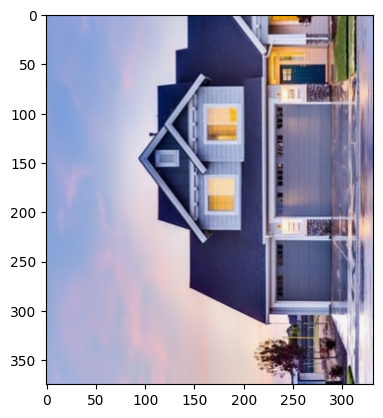

In [ ]:
plt.imshow(result1)

In [9]:
imgs2 = rotate(mirroring(imgs_list[2]))

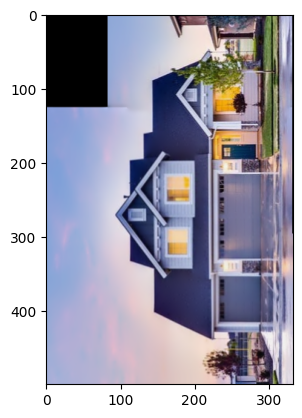

In [10]:
result2 = image_stitch(result1, imgs_list[0])
plt.imshow(result2)

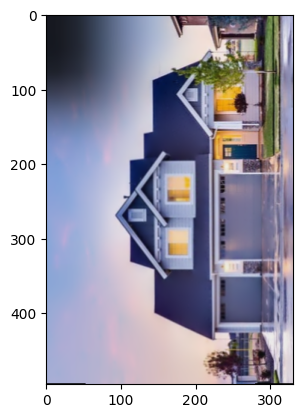

In [11]:
result3 = image_stitch(imgs2, result2)
plt.imshow(result3)